In [1]:
#follow the command to install any package:
#!pip install torch


### Install Packages

In [2]:
#!pip install numpy==1.26.4

In [3]:
#Import the librarry

import numpy as np  # For mathematical computations and array operations
import torch  # For deep learning, tensor computations, and GPU acceleration
from torch.utils.data import Dataset, DataLoader, ConcatDataset  # For handling and loading datasets efficiently
import glob  # For file searching and pattern matching in directories to get the images
import matplotlib.pyplot as plt  # For data visualization and plotting graphs and see the model expriance in vizualize
from sklearn.metrics import confusion_matrix, accuracy_score  # For evaluating model performance, mainly Conf_Matrix
import random  # For generating random numbers and shuffling data
import cv2  # For image processing and computer vision tasks
import sys  # For system-specific parameters and functions, such as handling command-line arguments


### Reading the images:



##### Import the data from :https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?resource=download




In [4]:
tumor = []
healthy=[]

#Matches .png, .jpeg, .jpg, .JPG, .JPEG, .PNG (case-insensitive).

    #[pPjJ] → Matches p, P, j, or J (for png, jpg, jpeg).

    #[nNpP]* → Matches optional n, N, or p, P (for png, jpeg).

    #[gG] → Ensures it ends with g or G.

path = './archive/brain_tumor_dataset/yes/*.[pPjJ][nNpP]*[gG]' 

for f in glob.iglob(path):
    img = cv2.imread(f) # Reading the each image from the path
    
    #Since the data has different dimension, we have to have conssistant dimensions.
    #Let's fix it 
    img = cv2.resize(img, (128,128)) # the dimension of the image set or resize  to 128x128pxl
   
    #Not essentiall but nice to have conventionally 
    b, g, r = cv2.split(img) # spliting the image in blue, green, and red Channals
    img = cv2.merge([r, g, b]) # Then Merge by red, green, blue (RGB) order
    
    tumor.append(img) # Append the img to tumor list 
    
print ("Tumor count:",len(tumor))


healthy=[]

for f in glob.iglob("./archive/brain_tumor_dataset/no/*.[pPjJ][nNpP]*[gG]"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

print ("Healthy count:", len(healthy))

Tumor count: 155
Healthy count: 98


In [5]:
#Check the size of the image
for i in tumor[1:5]:
    print("This are the sape of the image:", i.shape)
#128 by 128 dimension by 3 channals (RGB)

This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)


In [6]:
#Convert to array
healthy = np.array(healthy)
tumor = np.array(tumor)


In [7]:
print(tumor.shape)
print(healthy.shape)
# For example: For healthy we have 155 image, with 3 channals in dimension of 128 x128 pxl

(155, 128, 128, 3)
(98, 128, 128, 3)


In [8]:
ALL = np.concatenate((healthy, tumor))
print(ALL.shape) # the image joined and become 155 + 98 = 253.

(253, 128, 128, 3)


In [9]:
# Select three random image/number between 0 to 4 [among five indeces value] using np.random.choice.
np.random.choice(5, 3, replace = False) #replace Helps that are not duplicate the same number at the same time. 

array([2, 0, 1])

### Visualize the MRI image

AxesImage(shape=(128, 128, 3))


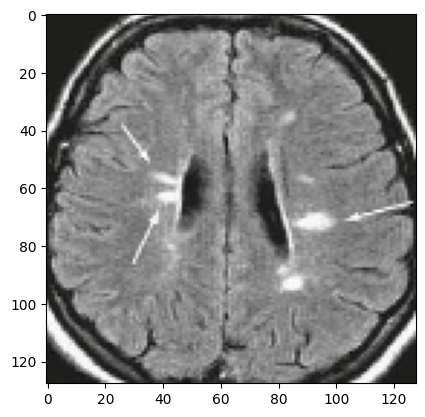

In [10]:
print(plt.imshow(healthy[0])) # Healthy Brain Image

AxesImage(shape=(128, 128, 3))


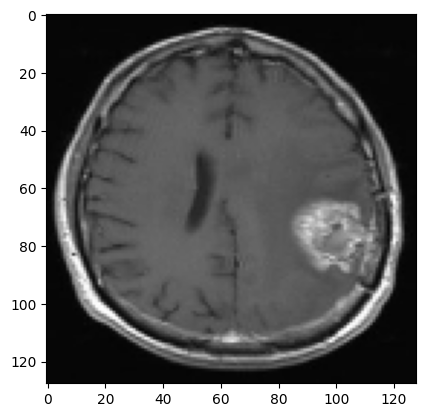

In [11]:
print(plt.imshow(tumor[0])) # Healthy Brain Image

In [12]:
# Let's Create a function that can pull 5 random image from the image data and shows in order with two classifications 

def plot_random(healthy, tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace = False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace = False)]

    plt.figure(figsize = (16,9))
    for i in range(num):
        plt.subplot(1, num, i+1) # i+1 because we can not plot indeces 0, so we can pull the first 1 by adding 1 in i.
        plt.title ("healthy")
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize = (16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title ("Tumor")
        plt.imshow(tumor_imgs[i])
   
   

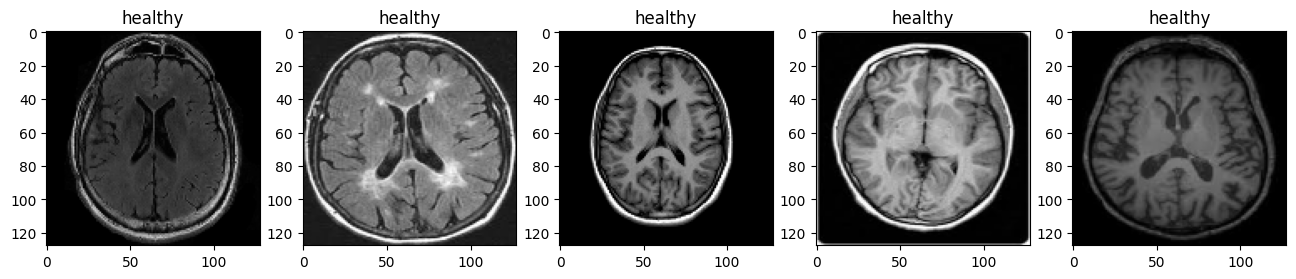

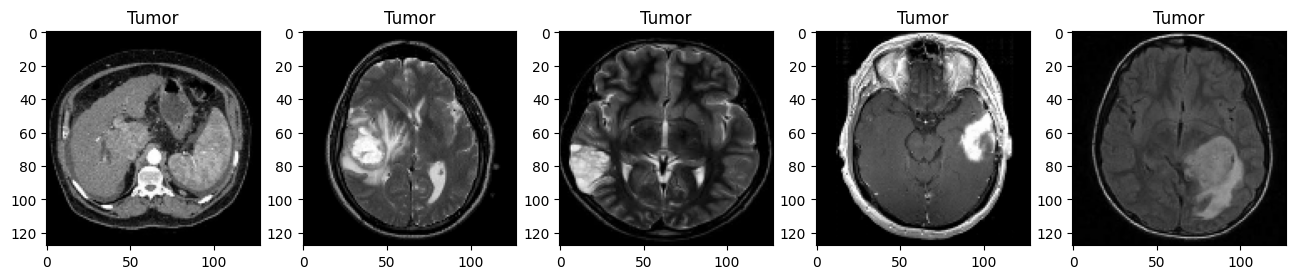

In [13]:
plot_random(healthy, tumor, num = 5)

In [14]:
# Let's Create torch data set from the image

#### Torch DataSets

In [15]:
# We have to overide or simply creating new module/class some class in pytorch! To do this Let's see an example:

class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Any assigned dataset from this class can override add as concatenate two data set. we can also modify __getitem__ by replacing 
# "raise NotImplementedError" with some function like self.x[index], you might get some result. The point is we have to ovveride the class, or create a new 
# class from the above dataset(). watch: https://www.youtube.com/watch?v=uvvuDjzjKio&list=PL5foUFuneQnratPPuucpVxWl4RlqueP1u&index=7 



##### Any assigned dataset from this class can override add as concatenate two data set. we can also modify __getitem__ by replacing  "raise NotImplementedError" with some function like self.x[index], you might get some result. The point is we have to ovveride the class, or create a new  class from the above dataset(). 

##### With bing that said, let's Create a Customized Pytorch Class!

### Pythorch Customized Class!

In [16]:
#This calss contain everything and access it and implemented automatically, insted we can finish everything outside and pass the data to the class at the end
class MRI(Dataset):
    
    def __init__(self):
        
        tumor = []
        path = './archive/brain_tumor_dataset/yes/*.[pPjJ][nNpP]*[gG]' 

        for f in glob.iglob(path):
            img = cv2.imread(f) # Reading the each image from the path
            
            #Since the data has different dimension, we have to have conssistant dimensions.
            #Let's fix it 
            img = cv2.resize(img, (128,128)) # the dimension of the image set or resize  to 128x128pxl
           
            #Not essentiall but nice to have conventionally 
            b, g, r = cv2.split(img) # spliting the image in blue, green, and red Channals
            img = cv2.merge([r, g, b]) # Then Merge by red, green, blue (RGB) order
            
            tumor.append(img) # Append the img to tumor list 
            
        #print ("Tumor count:",len(tumor))
        
        
        healthy=[]
        
        for f in glob.iglob("./archive/brain_tumor_dataset/no/*.[pPjJ][nNpP]*[gG]"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            healthy.append(img)
        
        #print ("Healthy count:", len(healthy))

        #Our Image is here in array with type of float
        healthy = np.array(healthy, dtype = np.float32)
        tumor = np.array(tumor, dtype = np.float32)


        #Our labels (0,1) is here in array with type of float.
        tumor_labels = np.ones(tumor.shape[0], dtype = np.float32) # Make it np.ones (1's) each image in tumor
        healthy_labels = np.zeros(healthy.shape[0], dtype = np.float32) # Make it np.zeros (0's) each image in tumor, it's fine to have float

        # We are going to self function for concatenate.
        # axis helps to add the first tumor on top of healthy, which make it (155, 128, 128) + (98, 128, 128) = (243, 128, 128)
        self.images = np.concatenate((tumor, healthy), axis = 0) 
        self.labels = np.concatenate((tumor_labels, healthy_labels), axis = 0)

    
    def __len__ (self):
        return self.images.shape[0] # we are creating like global len() func by returning only self.image.shape[0], which is the first element of shape tuple.
   
    
    def __getitem__(self, index):
        sample = {"images":self.images[index], "label": self.labels[index]} #Creating dict assists to pass two argument when index lodded to the class.
        return sample

    def normalize(self):
        self.images = self.images/255.0


In [17]:
mri = MRI()


In [18]:
#Normalize everything between 0 and 1
#mri.normalize()

### Data Loader

#### Let's see before a dataloder how it's look like!
* Data loder make it fast and easily suffile and dividded in mini-batch cause we have to. Nural network also need mini-batch.


In [19]:
#Let's Normalize!
mri.normalize()

image shape: (128, 128, 3)
image after: (128, 128, 3)


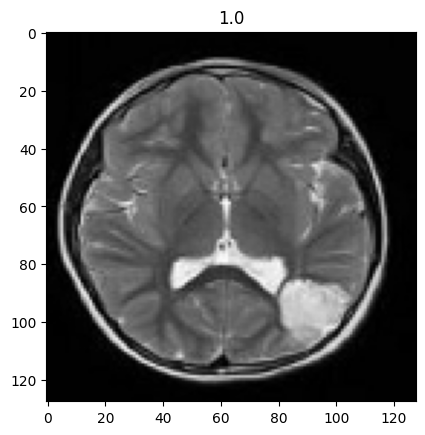

SystemExit: 

/opt/anaconda3/envs/MRI/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [20]:
index = list(range(len(mri))) # Creating a list for the images
random.shuffle(index) # Sufflling the index to corosponding images
for i in index:
    sample = mri[i]
    # print(sample)
    img = sample["images"]
    label = sample["label"]
    print("image shape:", img.shape)
    #img = img.reshape(img.shape[1], img.shape[2], img.shape[0]) # No need!, But incase - reshaping the image because the above dimension is channals , Hieght, width
    print("image after:", img.shape)
    plt.title(label)# 1 - Tumor, 0- Normal
    plt.imshow(img)
    plt.show()

    sys.exit() # Help us exit from the loop insted of terminating the cell!

####  Now, Let's come to easy way, which is a python has a command help us to itrate. I perfer to use this and it's really important, which is turn in to mini-batchs in this case I would say 10 mini batchs. Our MRI data set canb be itrate since we have dunder fun or a MRI class

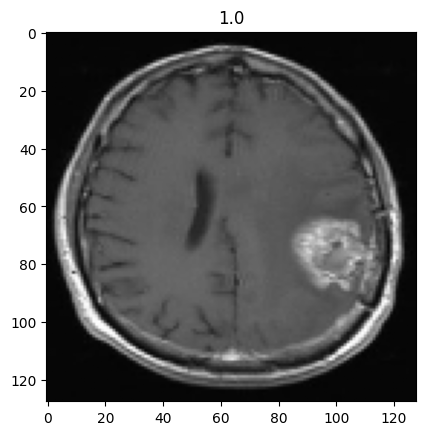

SystemExit: 

In [21]:
it = iter(mri)# itrating mri class and assigned by "itr"
print(it)
for i in range(10):# 10 mini batchs (dataset) itrable, which we can limit the number of image too.
    sample = next(it)
    img = sample["images"]
    label = sample["label"]
    plt.title(label)# 1 - Tumor, 0- Normal
    plt.imshow(img)
    plt.show()
    sys.exit()


### Data-loader fun from pythorch library

In [42]:
# dataloder from pytorch and put mri class, 
# batch_size - indicate that how many image will load to the itrations. This time 10 image lodded
dataloader = DataLoader(mri, batch_size = 10, shuffle = True)

In [43]:
for sample in dataloader:
    img = sample["images"].squeeze() # squeeze() will help us to remove the added dimension from the image 
    # torch.Size([1, 128, 128, 3]), - 1, shows the number of image with the dimensions.  
    print("image after:", img.shape)
    #plt.imshow(img)
    #plt.show()
    #sys.exit()

image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after: torch.Size([10, 128, 128, 3])
image after

### Building CNN - Convolutional Network



In [24]:
import torch.nn as nn 
import torch.nn.functional as F 

#let's create a class for CNN, pythorch needed a sub-class, which is module in this case.
# 

class CNN(nn.Module):
    def __init__(self): # It's a constructor, which is ablity to turn therm paramater objects.
        super(CNN, self).__init__() # Keeping everything what is in init above, and Super pass the name of the class and pointer(self), sub class 
        
        
        self.cnn_model = nn.Sequential( #nn can help you to choose 2d convo;utional dimension image paramater
            
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5 ),    # How many channals do we have for this first CNN layers, we have 3 channals, then out channals, which means how many CNN filters do we need, I chose to go with 6 filters/kernals. But, what size for filters. Kernal_size = 5, I chose 5 by 5.
        nn.Tanh(), # It's just mathimatical opreation (tangenth) implemented on 6 channals/filters fpr first CNN layers
        nn.AvgPool2d(kernel_size = 2, stride= 5), #This is sechond average linear layer. Pulling, average pooling in 2 dimensional (128,128), which is averageing the windows and getting out to small number of aggregated layers.  Stride is the higher stride the data willl crushed in dimensionally way.
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5 ), # Learn more future map by combining the egde and learn about if it's circle, rectangle what is looks the image. Filters go up to 16!
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 2, stride= 5)) # This is third average linear layer

        
        # Fully Connected Modeling in a squence.
        self.fc_model = nn.Sequential( 
        nn.Linear(in_features= 256, out_features=120), # we sort from 128x128 with three channals to 256 values, which is arbitrary numbers. How does it happen? read more!
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))  #the output looks like linear lines


    def forward(self, x): # x is image that passes to this fun.
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) # it's flatted 2d array. look the Supplment_documentation.ipynb
        x = self.fc_model(x)
        x = F.sigmoid(x) # pulling sigmoid because it's a binary classification.

        return x

   

In [25]:
model = CNN()

In [26]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [27]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [28]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [29]:
model.cnn_model[0].weight.shape # 6 filters, 3 channals, 5x5 dimensions. Note that, tehy sum up to one these channals then it's going to be converted 2d dimensions. that's why the out-put channals 6 channals.

torch.Size([6, 3, 5, 5])

In [30]:
model.cnn_model[0].weight[0].shape # three channals and 5x5 dimensions filters.
# torch.Size([3, 5, 5])

torch.Size([3, 5, 5])

Linear layer Model

In [31]:
model.fc_model[0].weight.shape # Full connection model has 120x120 dimension with 256 layer.

torch.Size([120, 256])

## Training and Evaluation in Pytorch
##### Assigning device for computations!

In [32]:
# Check if we have GPU first, if not we have to go to cpu
print(torch.cuda.is_available())

False


In [33]:
# device will be 'cuda' if a GPU is available - read supplment documentations.ipynb
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device) # Added this to the cuda, which is GPU.
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.9024, 0.6254, 0.2794, 0.4552, 0.6514, 0.9872, 0.4379, 0.2929, 0.7668,
        0.0120]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.9024, 0.6254, 0.2794, 0.4552, 0.6514, 0.9872, 0.4379, 0.2929, 0.7668,
        0.0120]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([8.1432e-01, 3.9114e-01, 7.8042e-02, 2.0723e-01, 4.2433e-01, 9.7460e-01,
        1.9177e-01, 8.5777e-02, 5.8791e-01, 1.4372e-04])


### Evaluate the model - first phase

In [34]:
mri_dataset = MRI()
mri_dataset.normalize() # normalize data betweem 0 to 1


In [35]:
# Let's define the device to run the model
device=torch.device('cpu:0') # I want to use GPU this case, but I don't have GPU on my mac, so I stick with cpu.

In [36]:
model = CNN().to(device)

In [37]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [38]:
print(torch.cuda.is_available())

False


In [39]:
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle=False) # data set, batch size is image number, but does not matter this case.

In [40]:
# model = CNN()
# #input_tensor = np.rand(32, 128, 128, 3)  # Wrong format
# input_tensor = input_tensor.permute(0, 3, 1, 2)  # Fix format: [N, C, H, W]

# output = model(input_tensor)
# print("Output shape:", output.shape)  # Should be [32, 1]

In [41]:
model.eval()

outputs = []
y_true = []

with torch.no_grad(): # No need gradient for now to avoid memory loss
    
    for d in dataloader:
        image = d["images"].to(device) # Sending the data to device since GPU dose not store data
        label = d["label"].to(device)
    
        y_hat = model(image)
    
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

    


RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[32, 128, 128, 3] to have 3 channels, but got 128 channels instead